#Step 1: Write your Segmentation Algoirthm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  Your algorithm must be based on thresholding and you should consider doing some region processing after segmentation to improve the result.

_Hint: You'll need to be a bit creative when devising your solution -- no single technique from class is likely to give you a particularly good solution, and you may need to think of some tricks that were not explicitly covered in class.  However, you can get a good result with a fairly simple algorithm.  You'll also need to decide how to handle the fact that the input images are colour, although this shouldn't pose too much of a problem, in fact, it is an advantage!_


In [98]:
import skimage.util as util
import skimage.io as io
import skimage.color as color
import skimage.morphology as morph
import numpy as np
import os as os

# You can import other modules as needed.

def segleaf(I):
    '''
    Segment a leaf image.
    :param I: Color leaf image to segment.
    :return: Logical image where True pixels represent foreground (i.e. leaf pixels).
    '''
    I_thres = np.zeros((I.shape[0], I.shape[1]), dtype=bool)
    
    for row in range(I_thres.shape[0]):
        for col in range(I_thres.shape[1]):
            if (((I[row, col, 1] + 0.0) - (I[row, col, 0] + 0.0)) > 1) and (((I[row, col, 1] + 0.0) - (I[row, col, 2] + 0.0)) > 1) and (I[row, col, 1] < 160):
                if col > (I_thres.shape[1] / 10.0):
                    I_thres[row, col] = True
    I_thres = morph.remove_small_holes(I_thres, min_size=8192) 
    I_thres = morph.remove_small_objects(I_thres, min_size=21750)
    return I_thres

# Step 2: Implment Measures

Write functions to compute the Mean Squared Distance (MSD), Hausdorff Distance (HD) and Dice Similarity Coefficient (DSC) measures of segmentation quality.  

For MSD and HD, I suggest you reprsent boundaries by N-row, 2-column arrays where each row is the coordinate of one pixel on the region's boundary of the form [r,c], row first, then column.

In [99]:
import skimage.segmentation as seg

def measures(I_seg, Igt):
    if Igt.dtype != np.bool:
        I_gt = Igt > 125
    
    union = np.sum(np.logical_and(I_seg, I_gt))
    dsc = union * 2.0 / (np.sum(I_seg) + np.sum(I_gt))
    L_iseg = morph.label(I_seg, connectivity=2)
    L_igt = morph.label(I_gt, connectivity=2)
    bp_iseg = np.where(seg.find_boundaries(L_iseg, connectivity=2, mode='inner') > 0)
    bp_igt = np.where(seg.find_boundaries(L_igt, connectivity=2, mode='inner') > 0)
    bp_iseg = np.transpose(np.vstack(bp_iseg))
    bp_igt = np.transpose(np.vstack(bp_igt))
    nop_iseg = bp_iseg.shape[0]
    nop_igt = bp_igt.shape[0]
    BP_iseg = np.tile(np.expand_dims(bp_iseg, axis=2), (1, 1, bp_igt.shape[0])) * 1.0
    BP_igt = np.tile(np.expand_dims(bp_igt, axis=2), (1, 1, bp_iseg.shape[0])) * 1.0
    result = np.sum(np.power((BP_igt - np.transpose(BP_iseg, (2, 1, 0))), 2), axis=1)
    result_sqrt = np.sqrt(result)
    msd = np.sum(np.amin(result, axis=0)) / nop_iseg
    hd = max(np.max(np.amin(result_sqrt, axis=0)), np.max(np.amin(result_sqrt, axis=1)))
    
    return (dsc, msd, hd)

# Step 3: Write a Validation driver program.

Write code that segments each image, and computes the MSD, HD, and DSC for each segmentation.  Print the MSD, HD, and DSC of each segmentation as you perform it.  At the end, print the average and standard deviation of the DSC, the MSD and the HD over all of the images.  Also print the percentage of regions that were "recognized" (see below).  Sample output is in the assignment description document.

The general approach should be, for each input image (in the `images` folder):

* load the image and it's ground truth
* segment the input image - this should be a binary image with a single region (connected component).
* extract the region boundary points from the segmented image and ground truth image; store them in Nx2 arrays as described above (see lecture nodes for an example on how to do this!).
* Compute the MSD and the HD from the two sets of boundary points (using the functions in Step 2).
* Compute the DSC from the segmented image and the ground truth image (using the function from Step 2).
* Determine whether the leaf was "recognized" (a leaf is recognized if it's DSC is greater than 0.6).
* Print the MSD, HD, and DSC to the console (see sample output).

When finished, don't forget to print the average and standard deviation of the DSC for all images, and the percentage of images where the leaf was "recognized".

_Feel free to define additional helper functions for your program if you think it will help._

In [100]:
import matplotlib.pyplot as plt

% matplotlib inline
#### Validate ####

# Paths for folders -- original and ground truth images
images_path = os.path.join('.', 'images')
gt_path = os.path.join('.', 'groundtruth')

dscl = []
msdl = []
hdl  = []
count_regc = 0
count_img = 0
best_hd = float('+inf')
worst_hd = 0

# Iterate over all files in the original images folder
for root, dirs, files in os.walk(images_path):
    for filename in files:
        # ignore files that are not PNG files.
        if filename[-4:] != '.png':
            continue
        
        # concatenate variable root with filename to get the path to an input file.
        count_img= count_img + 1
        fname = os.path.join(root, filename)
        I = io.imread(fname)
        gtfilename = 'threshimage_' + filename[-8:]
        I_gt = io.imread(os.path.join('groundtruth', gtfilename))
        I_thres = segleaf(I)
        #io.imsave(os.path.join('segmented', filename), util.img_as_uint(I_thres))
        dsc, msd, hd = measures(I_thres, I_gt)
        if dsc > 0.6:
            count_regc = count_regc + 1
        if hd > worst_hd:
            worst_hd = hd
            worst_img = I
            worst_img_gt = I_gt
            worst_img_seg = I_thres
        if hd < best_hd:
            best_hd = hd
            best_img = I
            best_img_gt = I_gt
            best_img_seg = I_thres
        print("DSC for %s: %.12f" % (filename, dsc))
        print("MSD for %s: %.12f" % (filename, msd))
        print("HD  for %s: %.12f" % (filename, hd))
        print("--------------------------------------------------")
        dscl.append(dsc)
        msdl.append(msd)
        hdl.append(hd)

print("The mean Dice coefficient was: %.12f" % np.mean(dscl))
print("The std. deviation of Dice coefficient was: %.12f" % np.std(dscl))
print("The mean MSD coefficient was: %.12f" % np.mean(msdl))
print("The std. deviation of MSD coefficient was: %.12f" % np.std(msdl))
print("The mean HD coefficient was: %.12f" % np.mean(hdl))
print("The std. deviation of HD coefficient was: %.12f" % np.std(hdl))
print("%.1f%% of leaves were recognized." % (count_regc * 100.0 / count_img))

/Users/wbb/anaconda3/envs/cmpt819/lib/python3.7/site-packages/skimage/morphology/misc.py:206: UserWarning: the min_size argument is deprecated and will be removed in 0.16. Use area_threshold instead.
  warn("the min_size argument is deprecated and will be removed in " +


DSC for image_0001.png: 0.992394963222
MSD for image_0001.png: 0.509146341463
HD  for image_0001.png: 3.605551275464
--------------------------------------------------
DSC for image_0002.png: 0.989250470709
MSD for image_0002.png: 0.777087646653
HD  for image_0002.png: 8.944271909999
--------------------------------------------------
DSC for image_0005.png: 0.988403082037
MSD for image_0005.png: 439.236988543372
HD  for image_0005.png: 116.520384482716
--------------------------------------------------
DSC for image_0007.png: 0.992972413231
MSD for image_0007.png: 0.774945375091
HD  for image_0007.png: 15.811388300842
--------------------------------------------------
DSC for image_0009.png: 0.993382506305
MSD for image_0009.png: 0.606186344776
HD  for image_0009.png: 13.000000000000
--------------------------------------------------
DSC for image_0010.png: 0.995016954508
MSD for image_0010.png: 0.900000000000
HD  for image_0010.png: 20.000000000000
------------------------------------

# Step 4:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (There is an example in the lecture notes -- last slide, Topic 6 -- showing how to do this).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


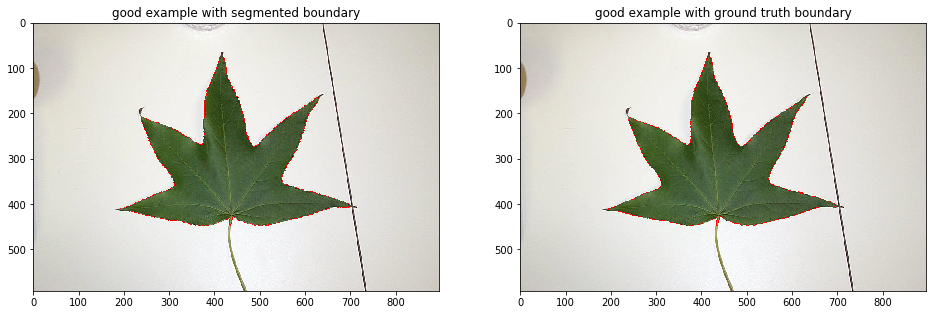

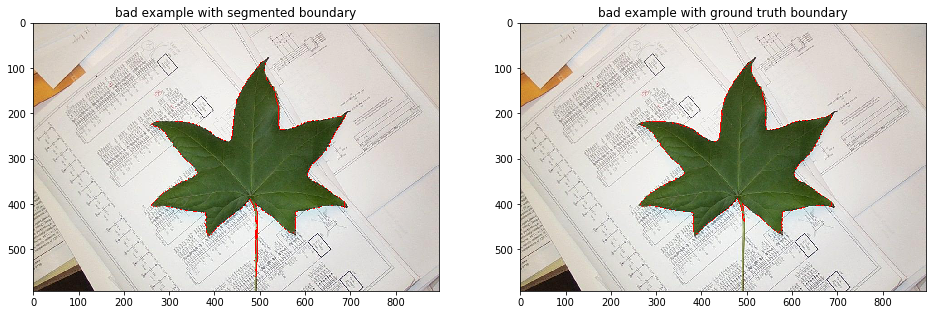

In [103]:
import matplotlib.pyplot as plt

% matplotlib inline

plt.subplots(1,2,figsize=(16, 6))
plt.subplot(1,2,1)
plt.title("good example with segmented boundary")
L_best_img_seg = morph.label(best_img_seg, connectivity=2)
best_image_with_boundaries_seg = seg.mark_boundaries(best_img, L_best_img_seg, color=(1,0,0))
plt.imshow(best_image_with_boundaries_seg)
plt.subplot(1,2,2)
plt.title("good example with ground truth boundary")
binary_best_img_gt = best_img_gt > 125
L_best_img_gt = morph.label(binary_best_img_gt, connectivity=2)
best_image_with_boundaries_gt = seg.mark_boundaries(best_img, L_best_img_gt, color=(1,0,0))
plt.imshow(best_image_with_boundaries_gt)

plt.subplots(1,2,figsize=(16, 6))
plt.subplot(1,2,1)
plt.title("bad example with segmented boundary")
L_worst_img_seg = morph.label(worst_img_seg, connectivity=2)
worst_image_with_boundaries_seg = seg.mark_boundaries(worst_img, L_worst_img_seg, color=(1,0,0))
plt.imshow(worst_image_with_boundaries_seg)
plt.subplot(1,2,2)
plt.title("bad example with ground truth boundary")
binary_worst_img_gt = worst_img_gt > 125
L_worst_img_gt = morph.label(binary_worst_img_gt, connectivity=2)
worst_image_with_boundaries_gt = seg.mark_boundaries(worst_img, L_worst_img_gt, color=(1,0,0))
plt.imshow(worst_image_with_boundaries_gt)


# Step 5: A time for reflection.

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_  Because leaves are green, so we choose those pixels whose values of G channel larger than values of R and B channels. Also leaves are pretty dark, so we ignore pixels whose values of G channel are too large. Finally, according to properties of images, we find leaves are located in the center of images. So we ignore objects in the margin.

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  

3. Consider your bad result.  What is it about your algoirthm caused the poor performance?   If you weren't able to get any results, leave this blank.

	_Your answer:_  My algorithm cannot exclude petioles very well during leaf detection, which causes the poor performance.
